In [1]:
import torch
import torch.nn as nn
import torchvision
import pickle as pkl
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**1. Вибір архітектур GAN:**


1. DCGAN (Deep Convolutional GAN): Реалізуйте DCGAN, що використовує згорткові шари для кращого захоплення просторових властивостей зображень.
2. WGAN (Wasserstein GAN): Спробуйте реалізувати WGAN для покращення стабільності навчання та якості генерації.



**2. Завантаження та попередня обробка даних:**
  * Завантажте набір даних MNIST (він доступний як в TensorFlow, так і в PyTorch).
  * Нормалізуйте значення пікселів до діапазону [-1, 1], що покращить процес навчання GAN.

In [3]:
torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

batch_size = 128
dataloader = DataLoader(dataset=dataset,
                         batch_size=batch_size,
                         shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 426kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.14MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
def generate_images(epoch, path, fixed_noise, num_test_samples, netG, device, use_fixed=False):
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)
    size_figure_grid = int(math.sqrt(num_test_samples))
    title = None

    if use_fixed:
        generated_fake_images = netG(fixed_noise)
        path += 'fixed_noise/'
        title = 'Fixed Noise'
    else:
        generated_fake_images = netG(z)
        path += 'variable_noise/'
        title = 'Variable Noise'

    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(generated_fake_images[k].data.cpu().numpy().reshape(28,28), cmap='Greys')
    label = 'Epoch_{}'.format(epoch+1)
    fig.text(0.5, 0.04, label, ha='center')
    fig.suptitle(title)
    fig.savefig(path+label+'.png')

**3. Налаштування архітектури кожного GAN**

**4. Методи налаштування (fine-tuning)**

**DCGAN (Deep Convolutional GAN)**

In [5]:
class DCGANGenerator(nn.Module):
    def __init__(self):
      super(DCGANGenerator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(100, 32*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(32*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(32*4, 32*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(32*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(32*2, 32, 4, 2, 1, bias=False),
          nn.BatchNorm2d(32),
          nn.ReLU(True),

          nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
          nn.Tanh()
      )

    def forward(self, input):
      output = self.network(input)
      return output

In [6]:
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(1, 32, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(32 * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32 * 2, 32 * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(32 * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32 * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

**WGAN (Wasserstein GAN)**

In [30]:
class WGANGenerator(nn.Module):
    def __init__(self):
      super(WGANGenerator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(100, 32*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(32*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(32*4, 32*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(32*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(32*2, 32, 4, 2, 1, bias=False),
          nn.BatchNorm2d(32),
          nn.ReLU(True),

          nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
          nn.Tanh()
      )

    def forward(self, input):
      output = self.network(input)
      return output

In [31]:
class WGANDiscriminator(nn.Module):
    def __init__(self):
        super(WGANDiscriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(1, 32, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(32 * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32 * 2, 32 * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(32 * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(32 * 4, 1, 4, 1, 0, bias=False)
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

**5. Навчання та порівняння архітектур**

**DGGAN**

In [20]:
import torch.optim as optim
netDCG = DCGANGenerator().to(device)
netDCD = DCGANDiscriminator().to(device)

criterion = nn.BCELoss()

optimizerDCG = optim.Adam(netDCG.parameters(), lr=0.0002)
optimizerDCD = optim.Adam(netDCD.parameters(), lr=0.0002)

Epoch [1/50], step [100/469], d_loss: 0.0468, g_loss: 4.8244
Epoch [1/50], step [200/469], d_loss: 0.0336, g_loss: 5.9826
Epoch [1/50], step [300/469], d_loss: 0.0203, g_loss: 5.7605
Epoch [1/50], step [400/469], d_loss: 0.0105, g_loss: 6.7541
Epoch [2/50], step [100/469], d_loss: 0.0196, g_loss: 6.1991
Epoch [2/50], step [200/469], d_loss: 0.0046, g_loss: 8.2645
Epoch [2/50], step [300/469], d_loss: 0.0124, g_loss: 7.4577
Epoch [2/50], step [400/469], d_loss: 0.0027, g_loss: 8.0342
Epoch [3/50], step [100/469], d_loss: 0.0082, g_loss: 8.0177
Epoch [3/50], step [200/469], d_loss: 0.0172, g_loss: 5.6144
Epoch [3/50], step [300/469], d_loss: 0.0172, g_loss: 6.9934
Epoch [3/50], step [400/469], d_loss: 0.0339, g_loss: 6.2842
Epoch [4/50], step [100/469], d_loss: 0.0216, g_loss: 7.8498
Epoch [4/50], step [200/469], d_loss: 0.0167, g_loss: 7.6308
Epoch [4/50], step [300/469], d_loss: 0.0122, g_loss: 7.2633
Epoch [4/50], step [400/469], d_loss: 0.0166, g_loss: 5.9685
Epoch [5/50], step [100/

<ipython-input-4-42fbed5c0598>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))


Epoch [22/50], step [100/469], d_loss: 0.3473, g_loss: 2.1258
Epoch [22/50], step [200/469], d_loss: 0.2277, g_loss: 1.9277
Epoch [22/50], step [300/469], d_loss: 0.4874, g_loss: 2.1689
Epoch [22/50], step [400/469], d_loss: 0.4714, g_loss: 2.8679
Epoch [23/50], step [100/469], d_loss: 0.2728, g_loss: 2.7390
Epoch [23/50], step [200/469], d_loss: 0.4149, g_loss: 3.1835
Epoch [23/50], step [300/469], d_loss: 0.2344, g_loss: 3.1582
Epoch [23/50], step [400/469], d_loss: 0.5504, g_loss: 3.1668
Epoch [24/50], step [100/469], d_loss: 0.5455, g_loss: 2.3186
Epoch [24/50], step [200/469], d_loss: 0.7843, g_loss: 2.9272
Epoch [24/50], step [300/469], d_loss: 0.3381, g_loss: 1.9076
Epoch [24/50], step [400/469], d_loss: 0.3594, g_loss: 2.6387
Epoch [25/50], step [100/469], d_loss: 0.4957, g_loss: 1.3144
Epoch [25/50], step [200/469], d_loss: 0.3613, g_loss: 1.8870
Epoch [25/50], step [300/469], d_loss: 0.2788, g_loss: 2.4825
Epoch [25/50], step [400/469], d_loss: 0.3957, g_loss: 2.7433
Epoch [2

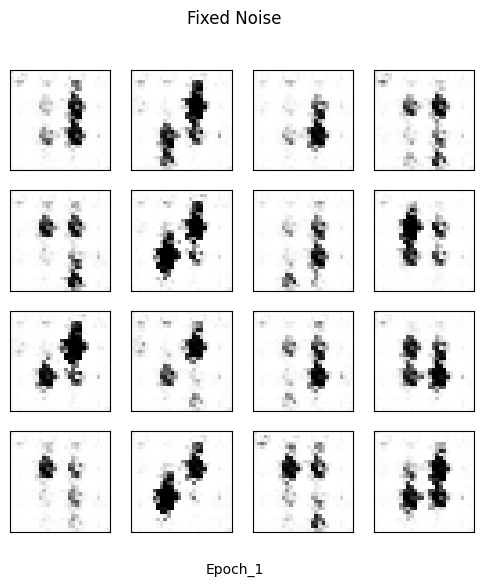

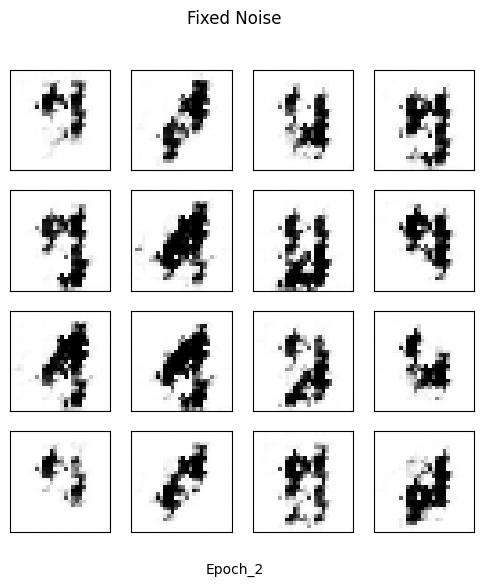

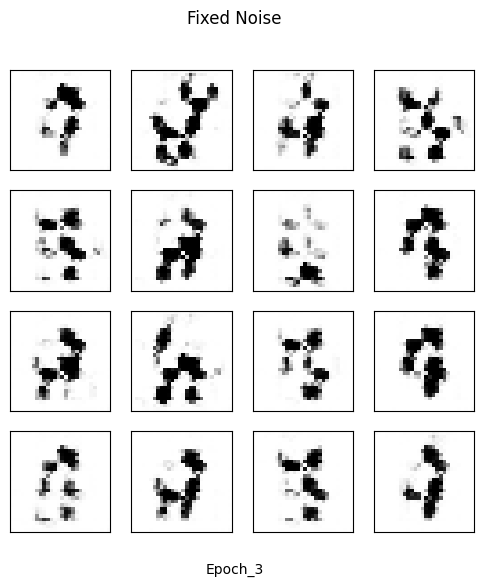

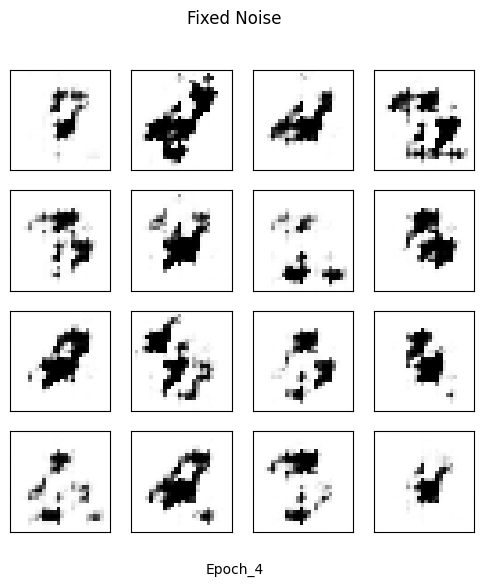

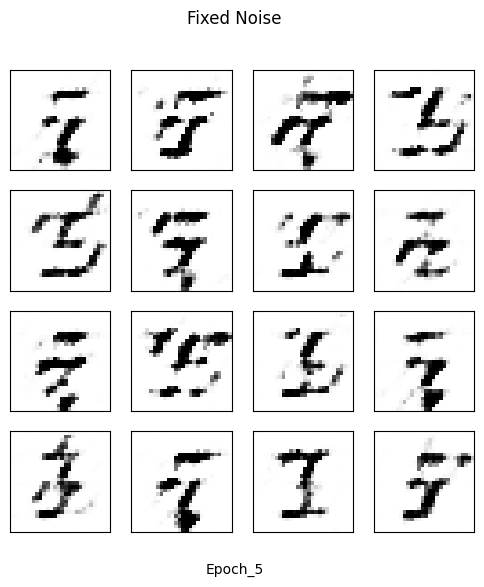

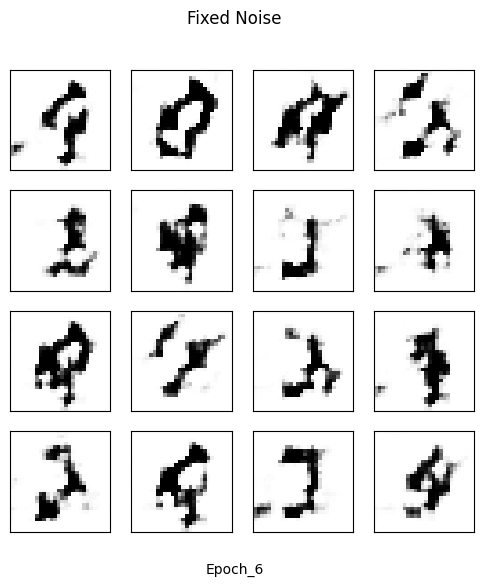

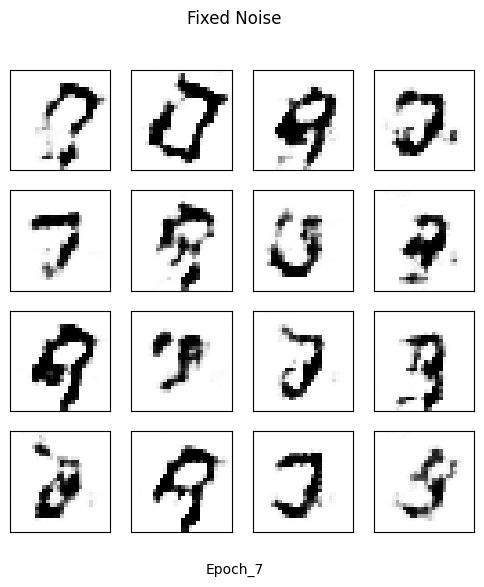

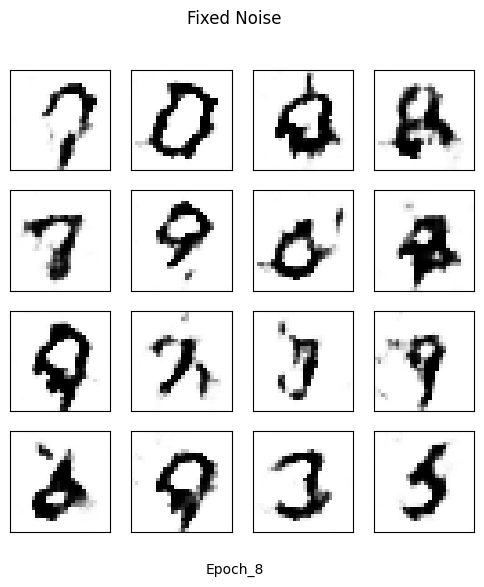

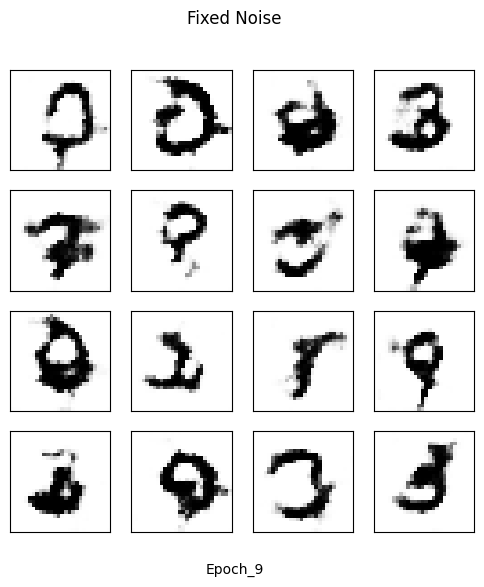

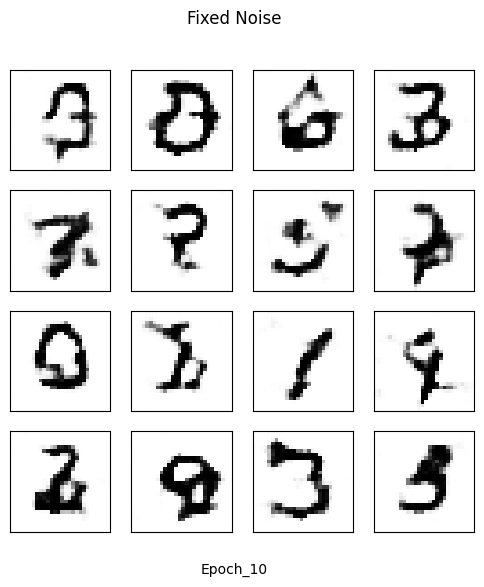

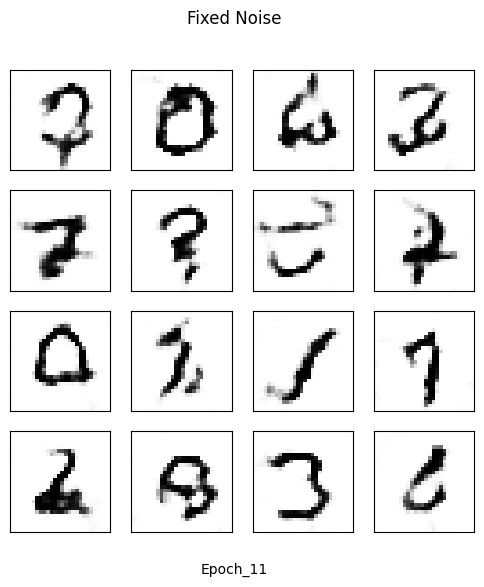

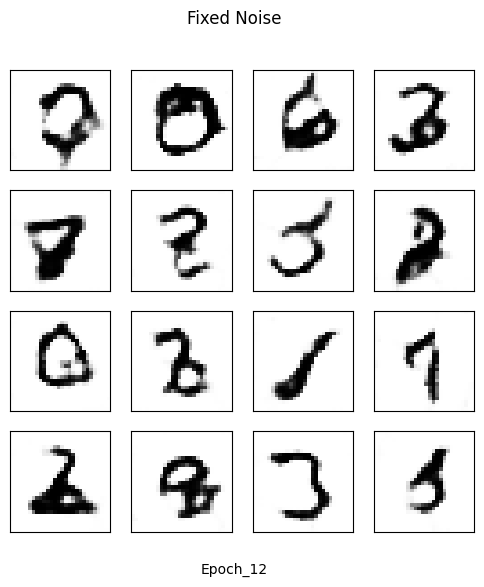

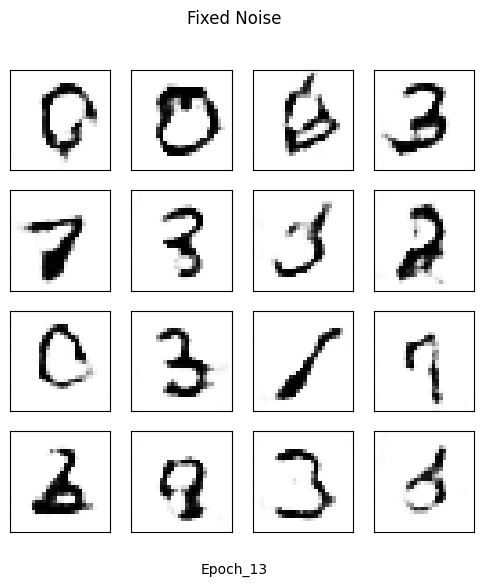

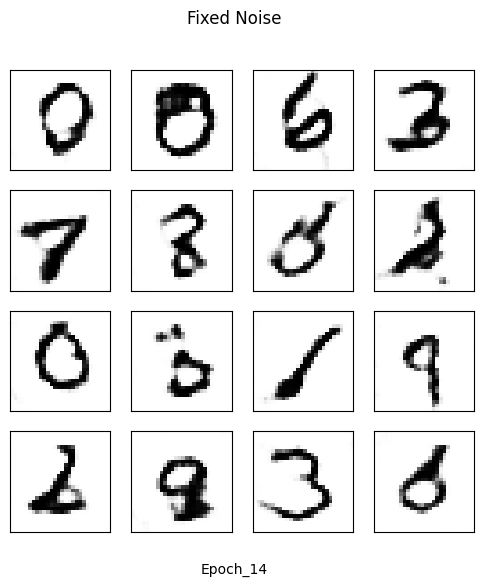

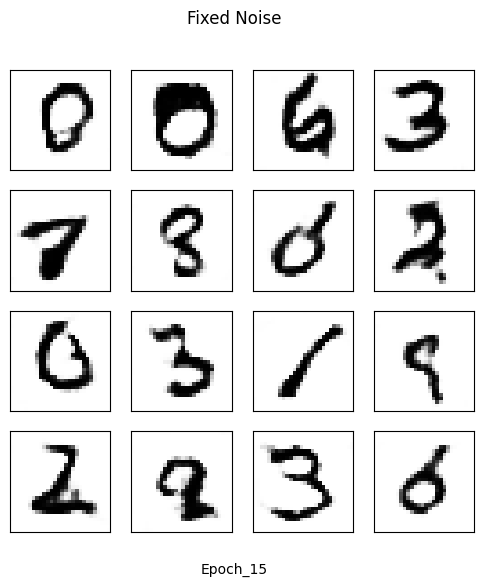

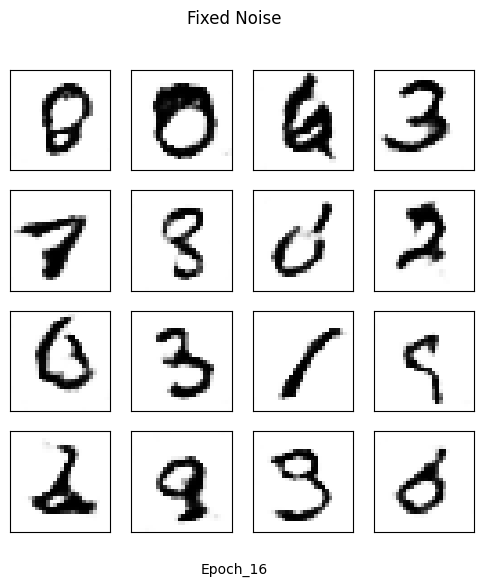

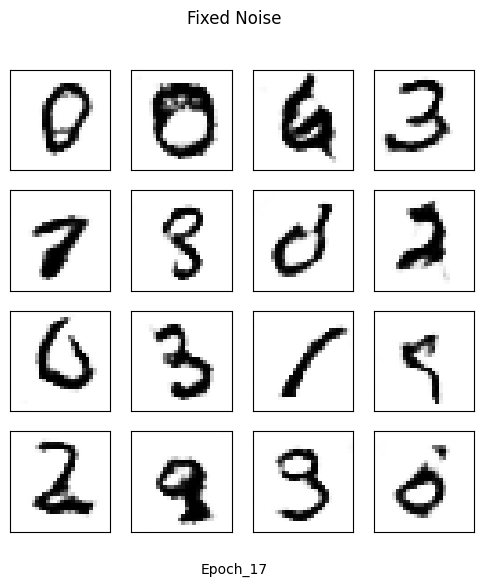

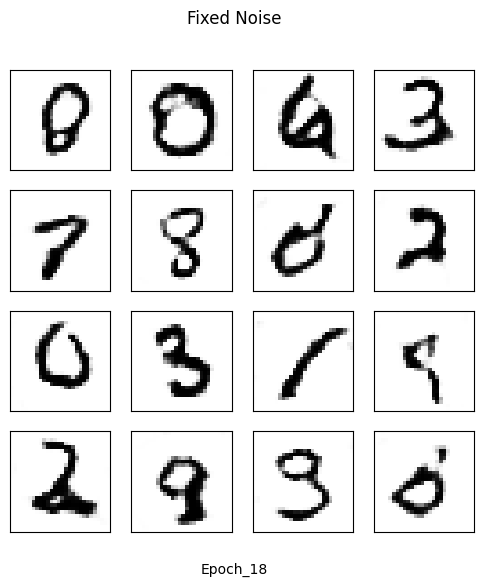

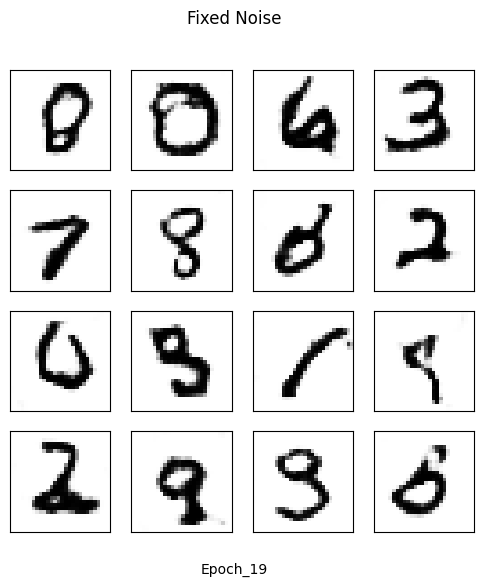

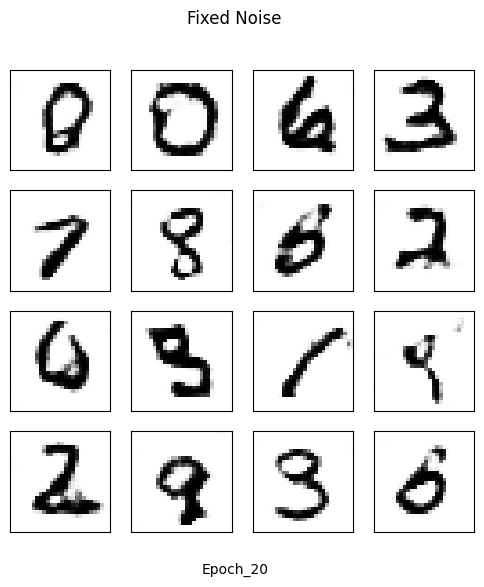

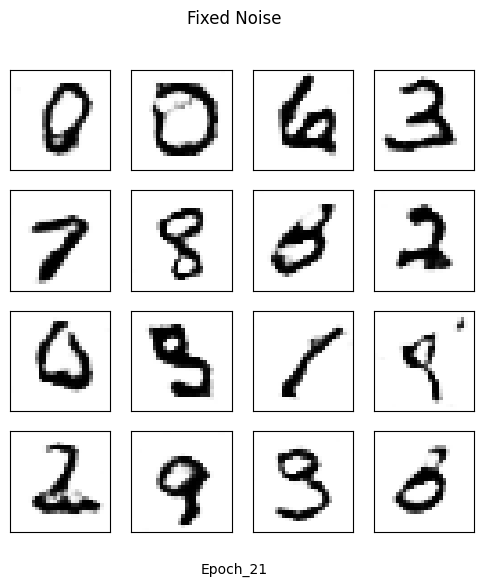

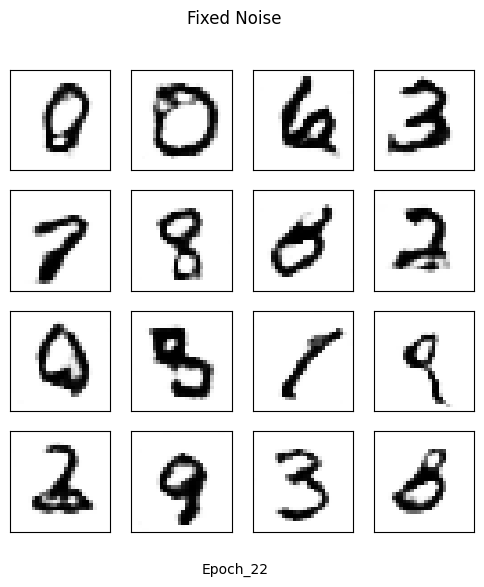

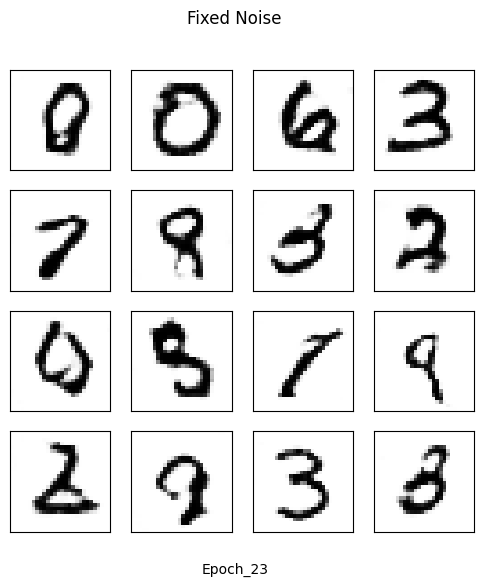

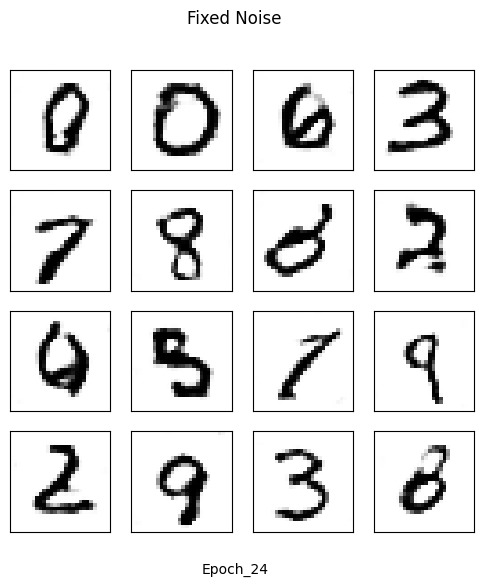

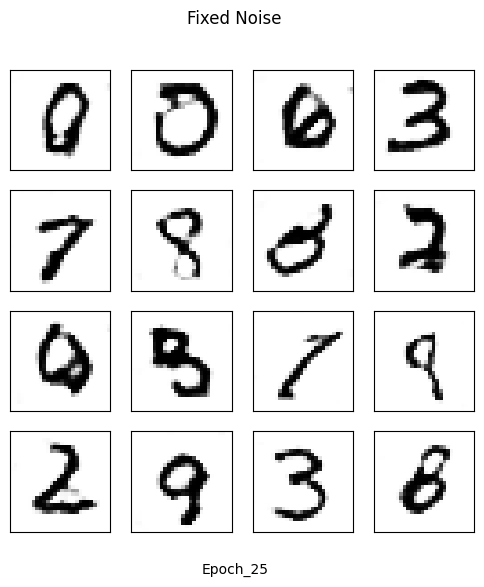

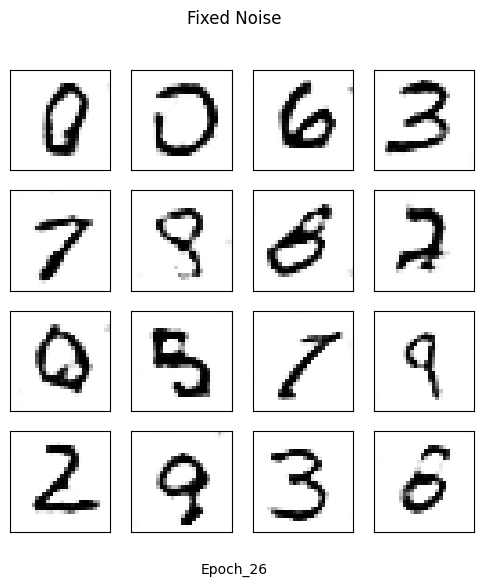

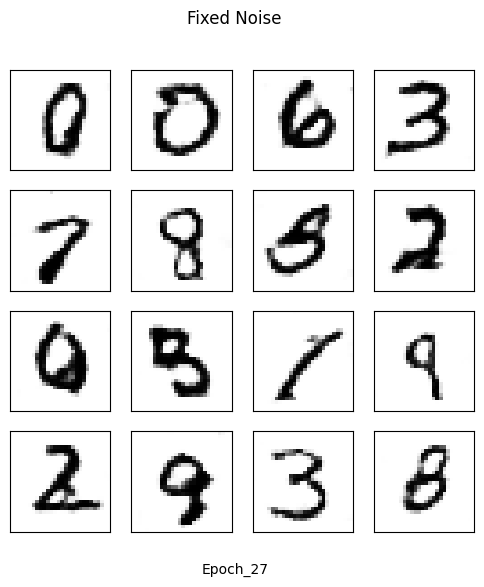

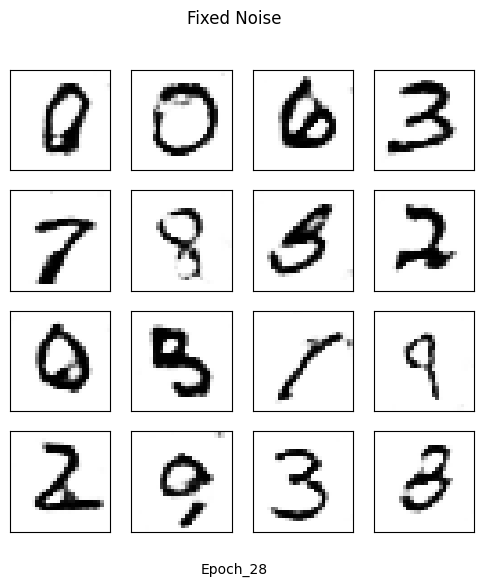

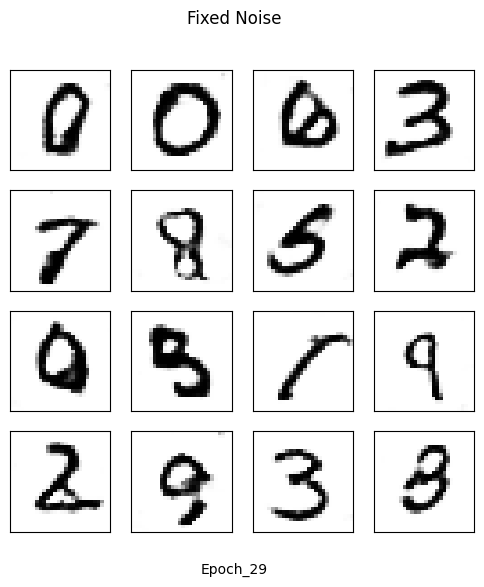

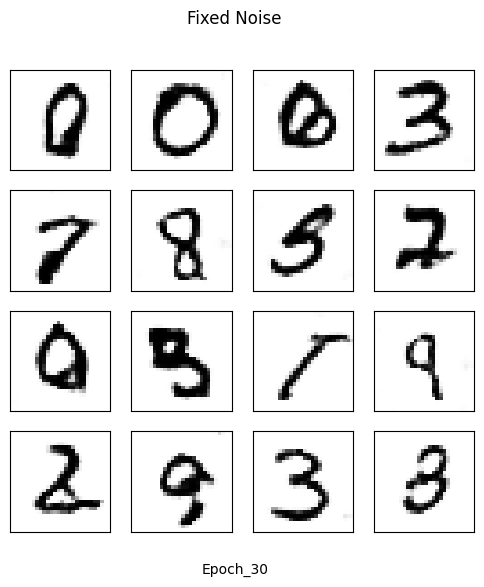

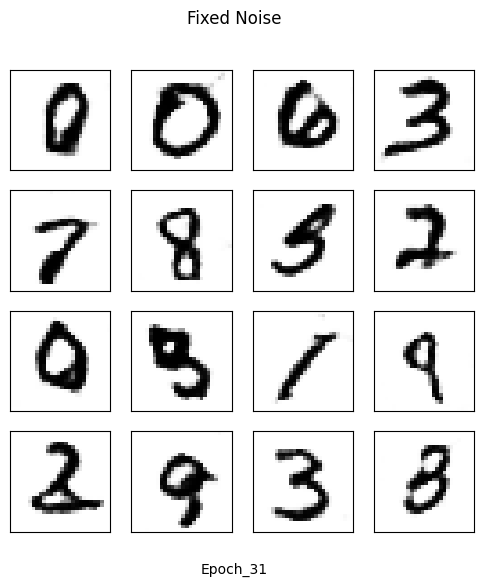

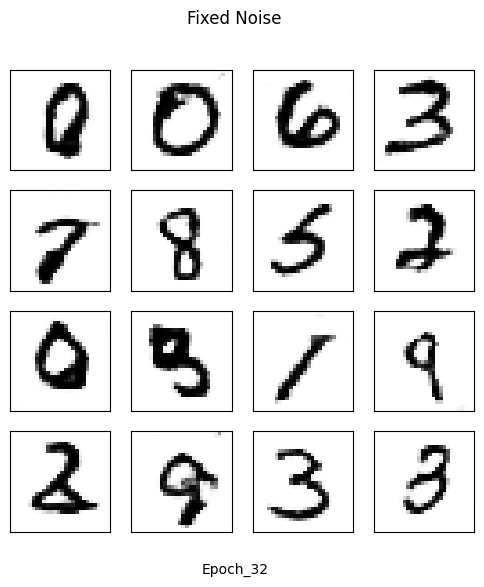

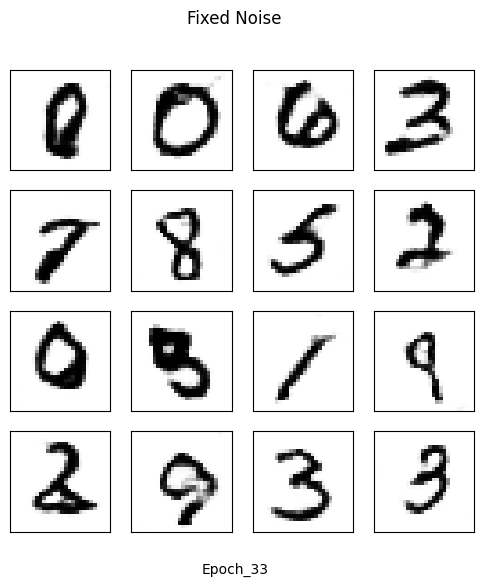

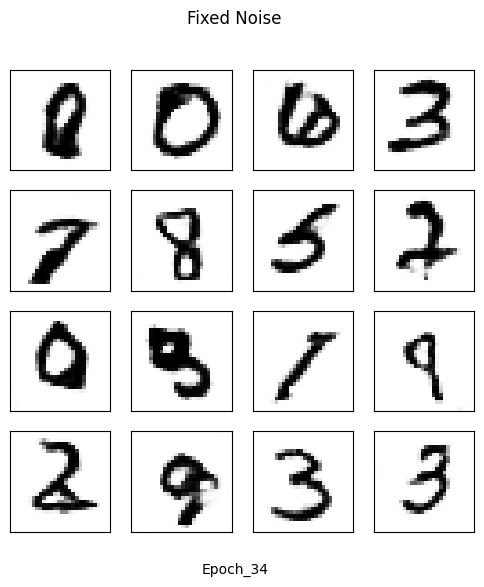

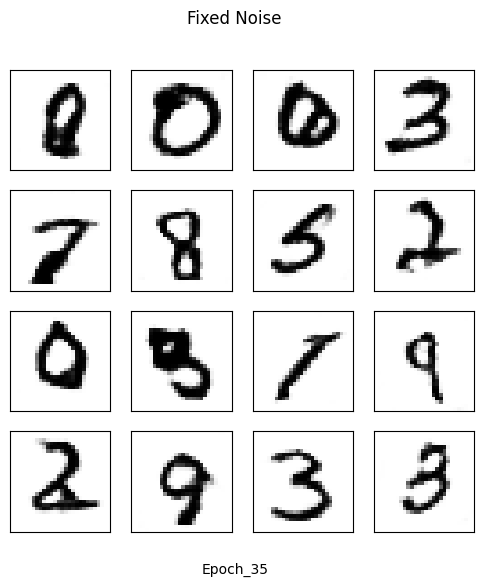

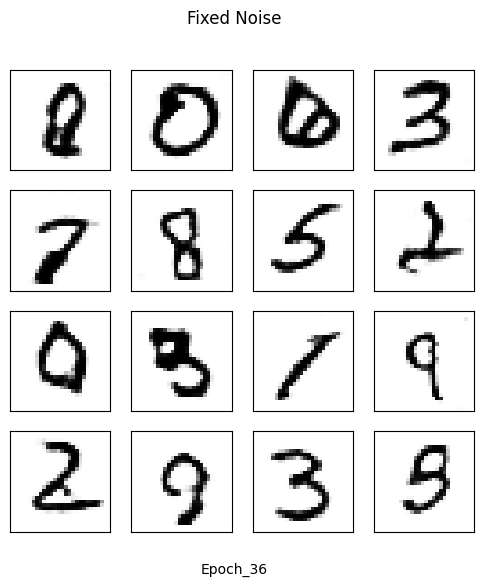

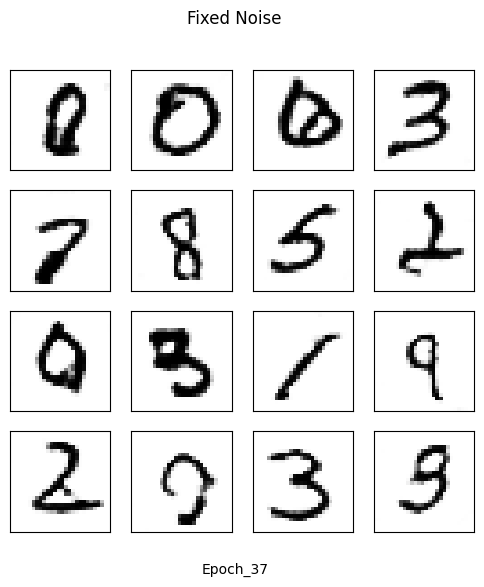

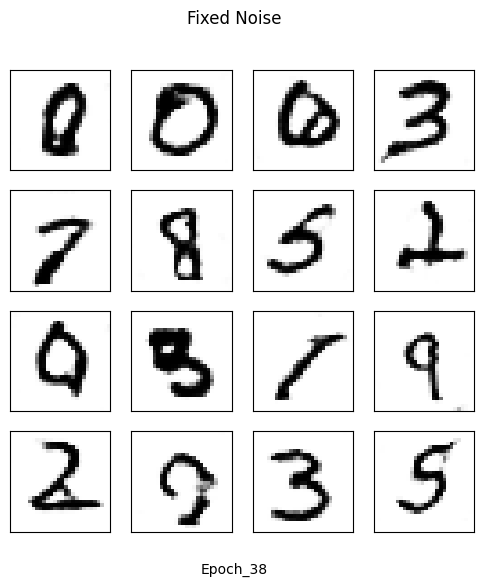

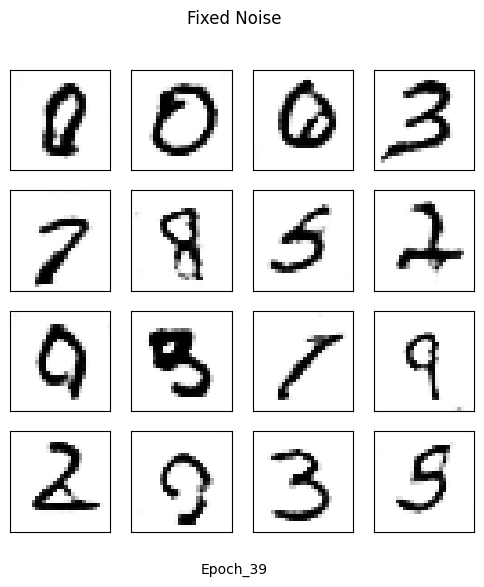

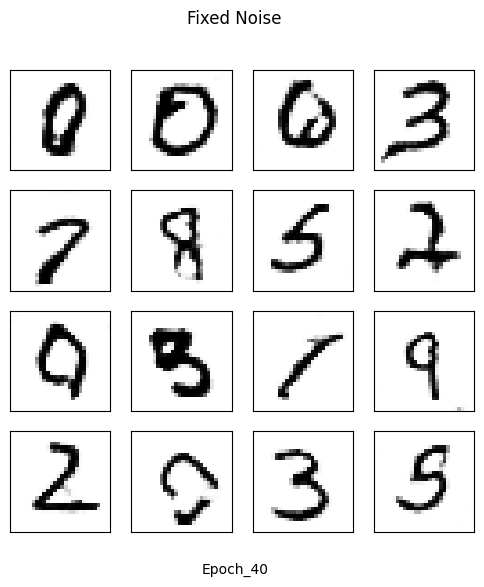

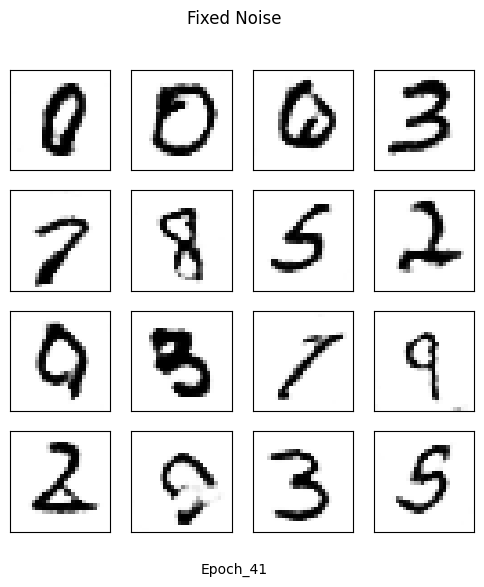

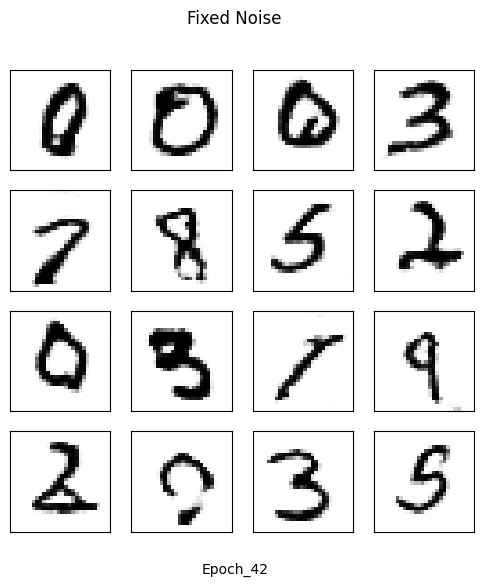

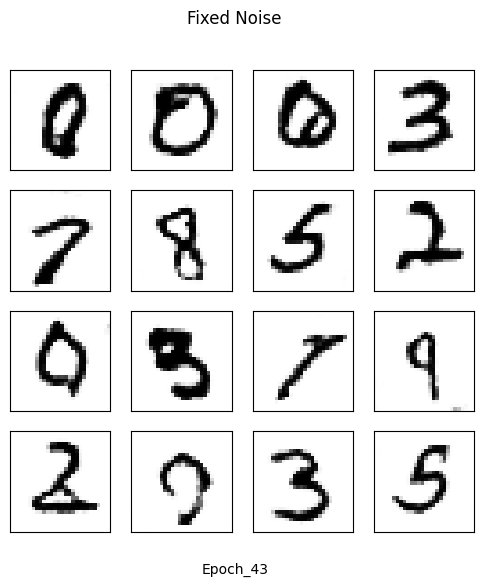

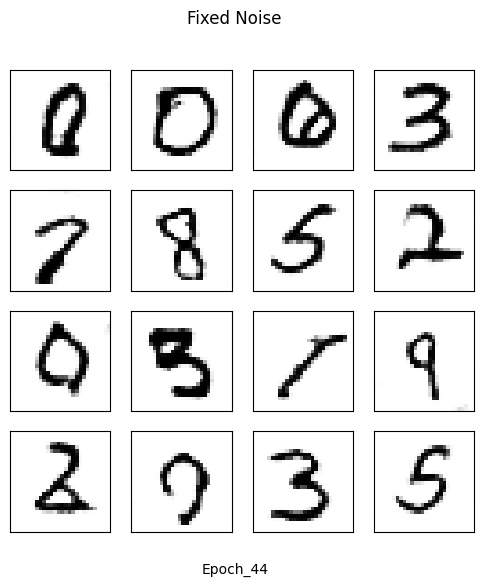

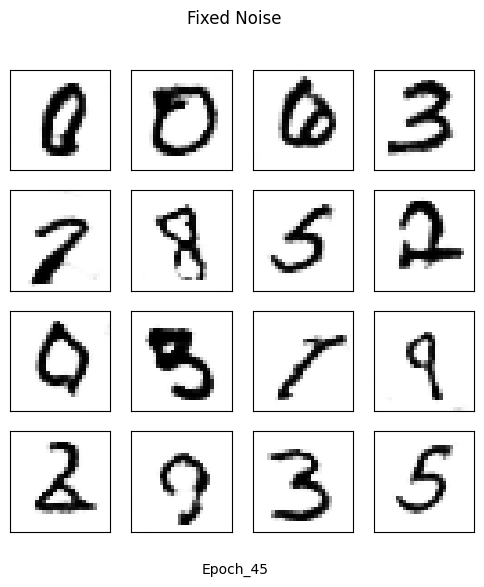

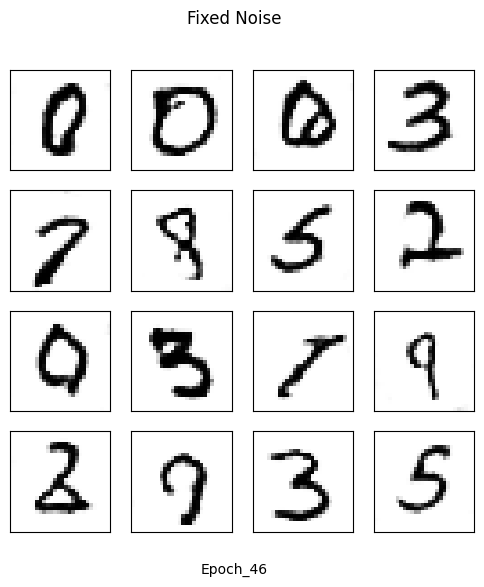

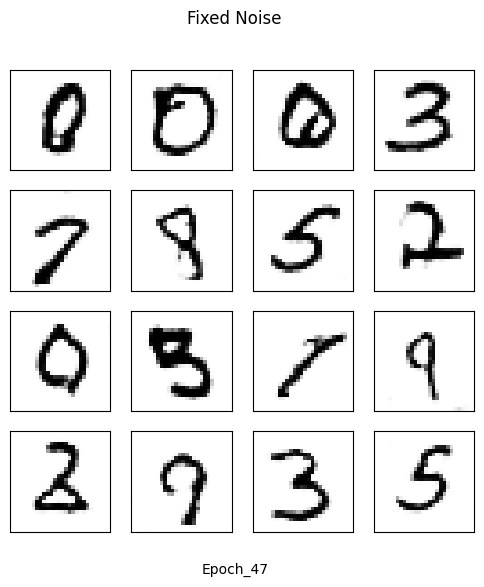

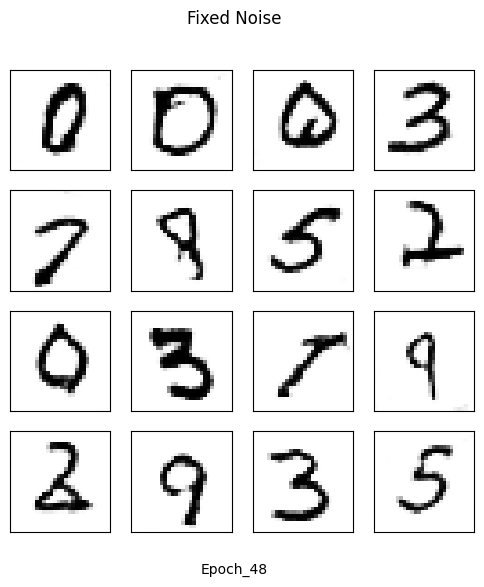

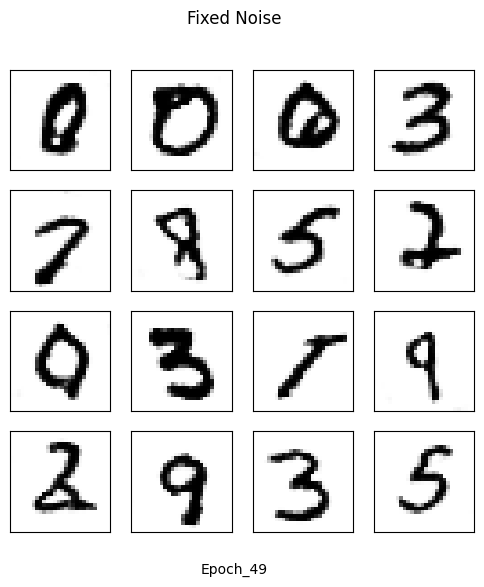

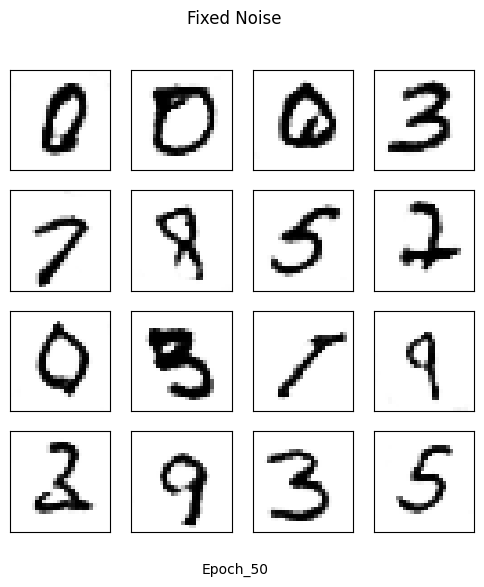

In [21]:
real_label = 1.0
fake_label = 0.0
num_batches = len(dataloader)
fixed_noise = torch.randn(16, 100, 1, 1, device = device)

dcd_losses = []
dcg_losses = []
num_epochs = 50


for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            bs = real_images.shape[0]
            ##############################
            #   Training discriminator   #
            ##############################

            netDCD.zero_grad()
            real_images = real_images.to(device)
            label = torch.full((bs,), real_label, device=device)

            output = netDCD(real_images)
            lossD_real = criterion(output, label)
            lossD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(bs, 100, 1, 1, device=device)
            fake_images = netDCG(noise)
            label.fill_(fake_label)
            output = netDCD(fake_images.detach())
            lossD_fake = criterion(output, label)
            lossD_fake.backward()
            D_G_z1 = output.mean().item()
            lossD = lossD_real + lossD_fake
            optimizerDCD.step()

            ##########################
            #   Training generator   #
            ##########################

            netDCG.zero_grad()
            label.fill_(real_label)
            output = netDCD(fake_images)
            lossG = criterion(output, label)
            lossG.backward()
            D_G_z2 = output.mean().item()
            optimizerDCG.step()

            if (i+1)%100 == 0:
                print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch+1, num_epochs,
                                                            i+1, num_batches, lossD.item(), lossG.item()))
          # Логування втрат
        d_epoch_loss = lossD.item()
        g_epoch_loss = lossG.item()
        dcd_losses.append(d_epoch_loss)
        dcg_losses.append(g_epoch_loss)
        netDCG.eval()
        generate_images(epoch, './results/DCGAN/', fixed_noise, 16, netDCG, device, use_fixed = 'store_true')
        netDCG.train()

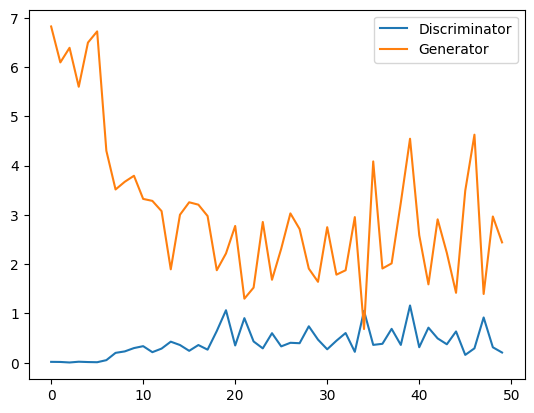

In [23]:
plt.plot(dcd_losses, label='Discriminator')
plt.plot(dcg_losses, label='Generator')
plt.legend()
plt.show()

**WGAN**

In [32]:
#WG GAN
netWGG = WGANGenerator().to(device)
netWGD = WGANDiscriminator().to(device)

# criterion = nn.BCELoss()

optimizerWGG = optim.RMSprop(netWGG.parameters(), lr=0.0005)
optimizerWGD = optim.RMSprop(netWGD.parameters(), lr=0.0005)

In [33]:
def discriminator_loss(real_output, fake_output):
    return -(torch.mean(real_output) - torch.mean(fake_output))  # Wasserstein distance

def generator_loss(fake_output):
    return -torch.mean(fake_output)

Epoch [1/50], step [100/469], d_loss: -0.1094, g_loss: 0.0477
Epoch [1/50], step [200/469], d_loss: -0.1462, g_loss: 0.1043
Epoch [1/50], step [300/469], d_loss: -0.1210, g_loss: 0.0909
Epoch [1/50], step [400/469], d_loss: -0.1144, g_loss: 0.0929
Epoch [2/50], step [100/469], d_loss: -0.0694, g_loss: -0.0109
Epoch [2/50], step [200/469], d_loss: -0.0929, g_loss: 0.0026
Epoch [2/50], step [300/469], d_loss: -0.0684, g_loss: 0.0152
Epoch [2/50], step [400/469], d_loss: -0.0630, g_loss: 0.0783
Epoch [3/50], step [100/469], d_loss: -0.0392, g_loss: 0.0020
Epoch [3/50], step [200/469], d_loss: -0.0431, g_loss: -0.0126
Epoch [3/50], step [300/469], d_loss: -0.0573, g_loss: 0.0247
Epoch [3/50], step [400/469], d_loss: -0.0419, g_loss: 0.0724
Epoch [4/50], step [100/469], d_loss: -0.0498, g_loss: -0.0105
Epoch [4/50], step [200/469], d_loss: -0.0423, g_loss: -0.0143
Epoch [4/50], step [300/469], d_loss: -0.0404, g_loss: 0.0958
Epoch [4/50], step [400/469], d_loss: -0.0494, g_loss: 0.0934
Epoc

<ipython-input-4-42fbed5c0598>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))


Epoch [22/50], step [100/469], d_loss: -0.0188, g_loss: -0.0624
Epoch [22/50], step [200/469], d_loss: -0.0118, g_loss: -0.0267
Epoch [22/50], step [300/469], d_loss: -0.0205, g_loss: 0.0417
Epoch [22/50], step [400/469], d_loss: -0.0199, g_loss: 0.0222
Epoch [23/50], step [100/469], d_loss: -0.0241, g_loss: 0.0044
Epoch [23/50], step [200/469], d_loss: -0.0085, g_loss: -0.0195
Epoch [23/50], step [300/469], d_loss: -0.0238, g_loss: 0.0584
Epoch [23/50], step [400/469], d_loss: -0.0120, g_loss: -0.0143
Epoch [24/50], step [100/469], d_loss: -0.0228, g_loss: -0.0482
Epoch [24/50], step [200/469], d_loss: -0.0216, g_loss: 0.0400
Epoch [24/50], step [300/469], d_loss: -0.0129, g_loss: 0.0739
Epoch [24/50], step [400/469], d_loss: -0.0107, g_loss: -0.0338
Epoch [25/50], step [100/469], d_loss: -0.0109, g_loss: 0.0686
Epoch [25/50], step [200/469], d_loss: -0.0162, g_loss: -0.0302
Epoch [25/50], step [300/469], d_loss: -0.0201, g_loss: -0.0133
Epoch [25/50], step [400/469], d_loss: -0.0122,

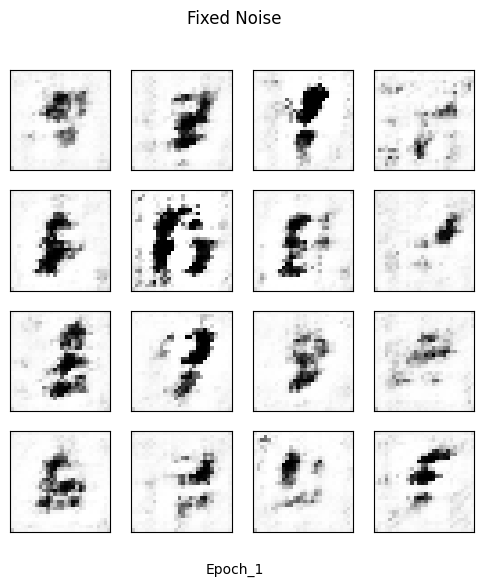

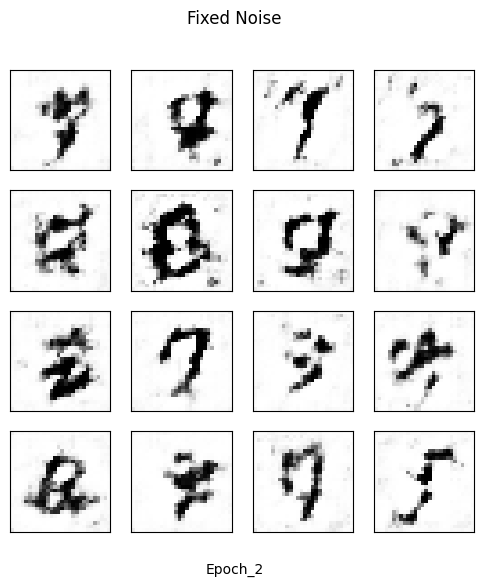

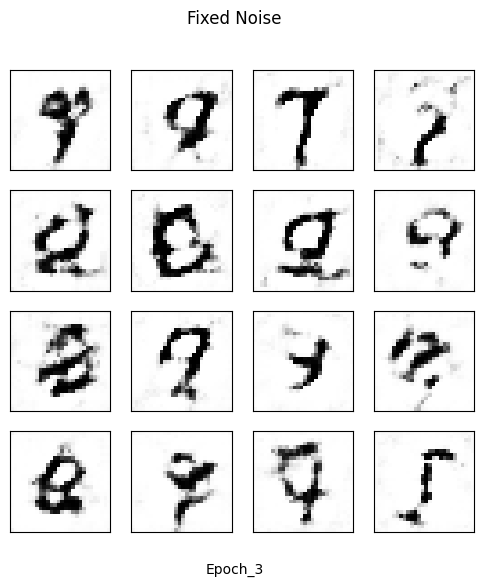

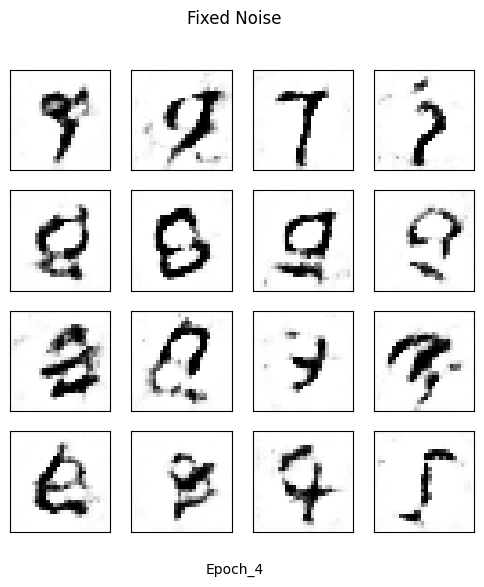

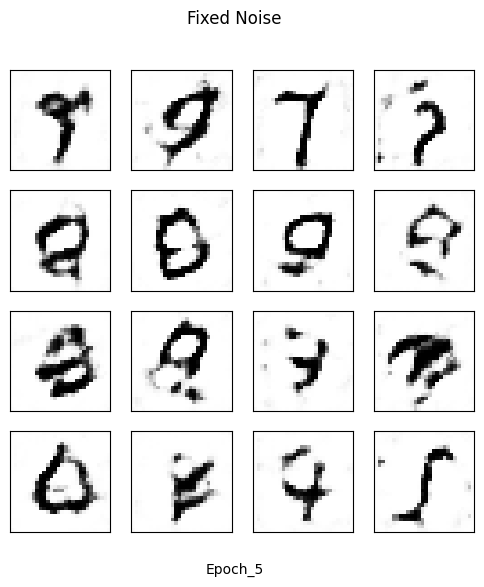

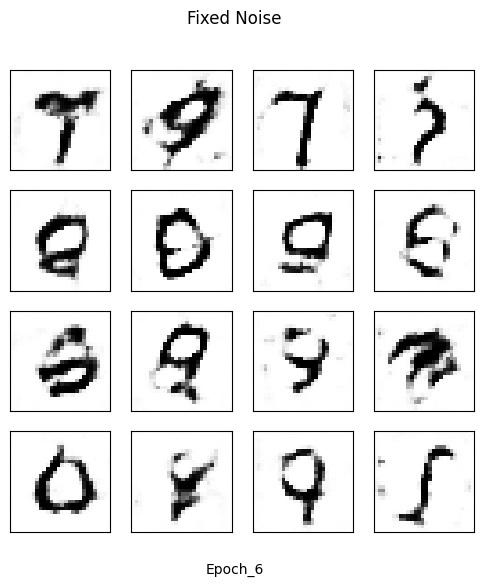

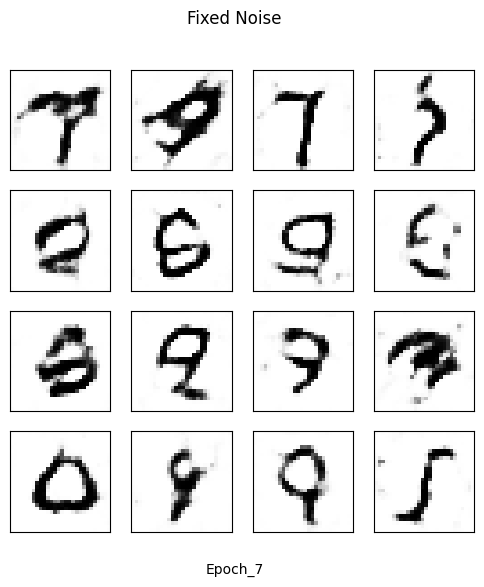

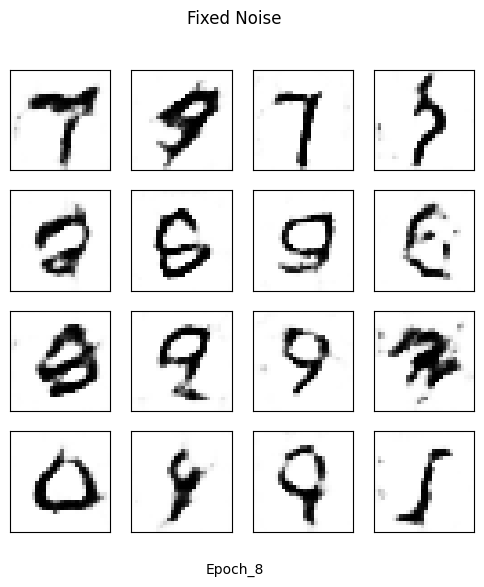

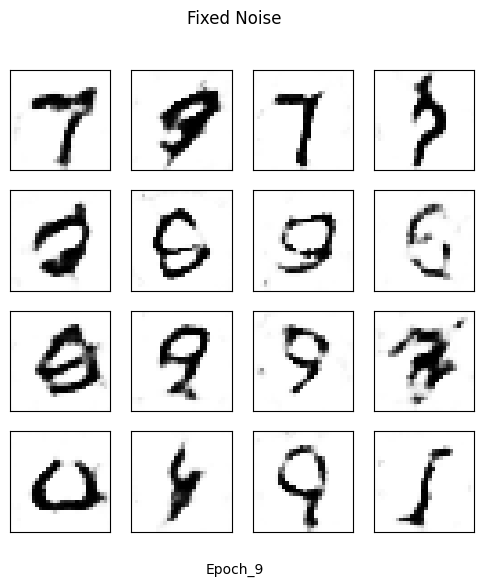

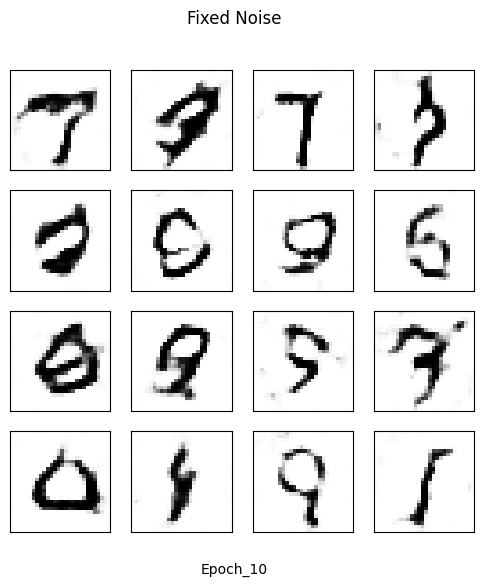

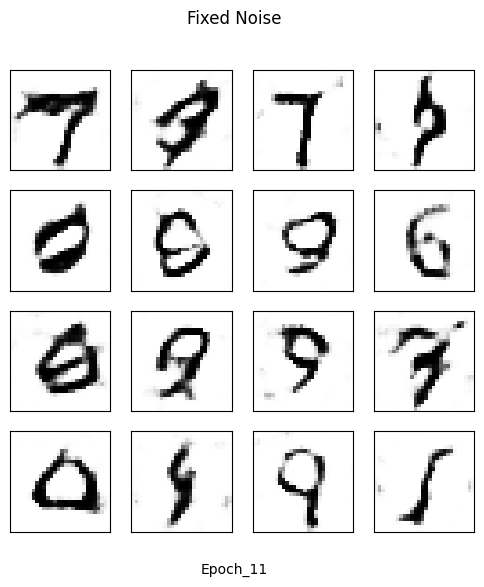

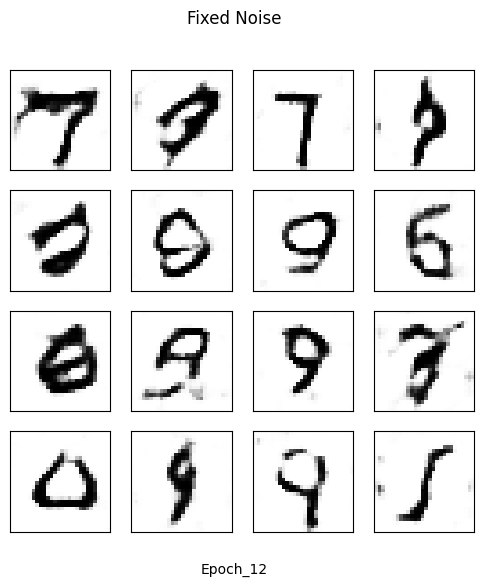

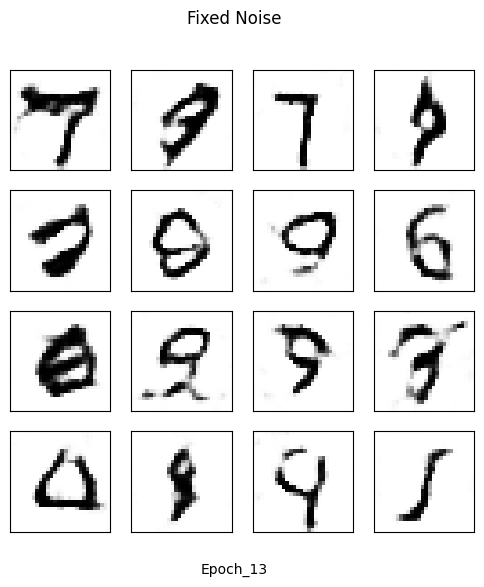

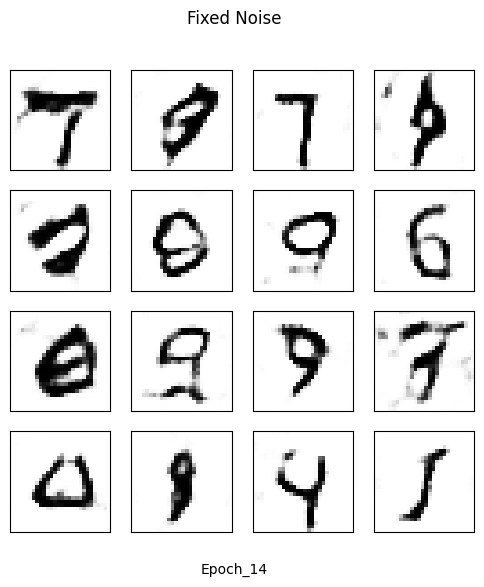

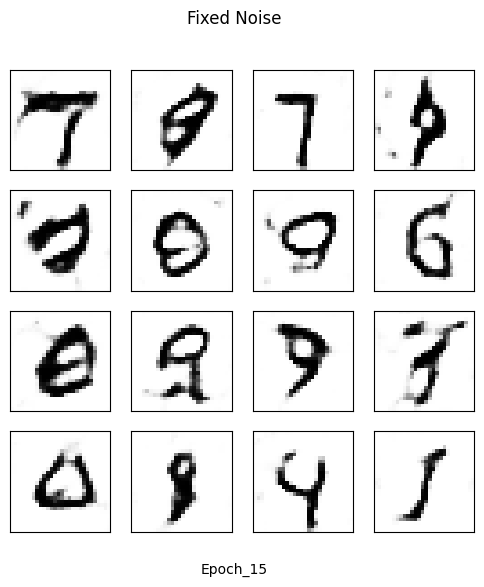

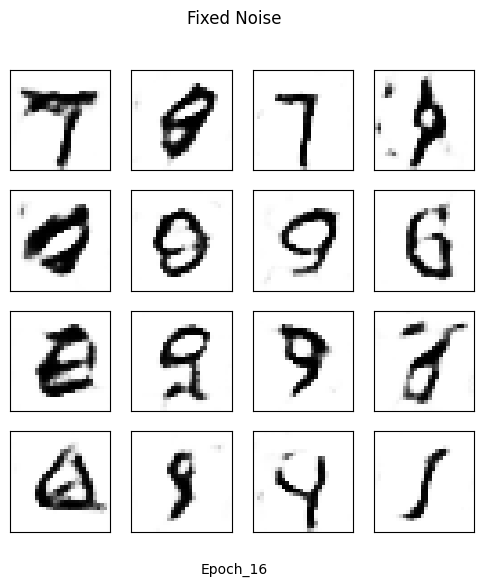

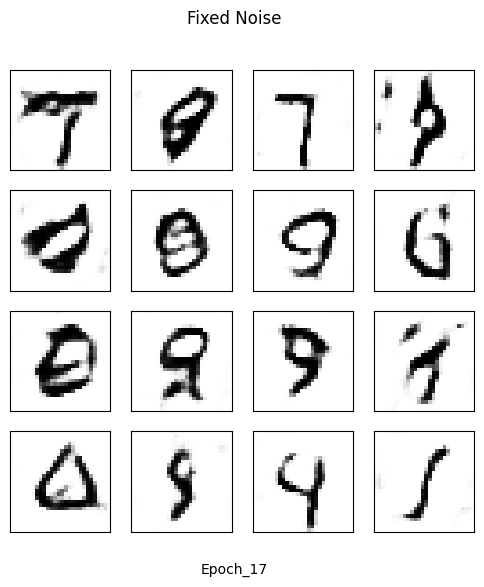

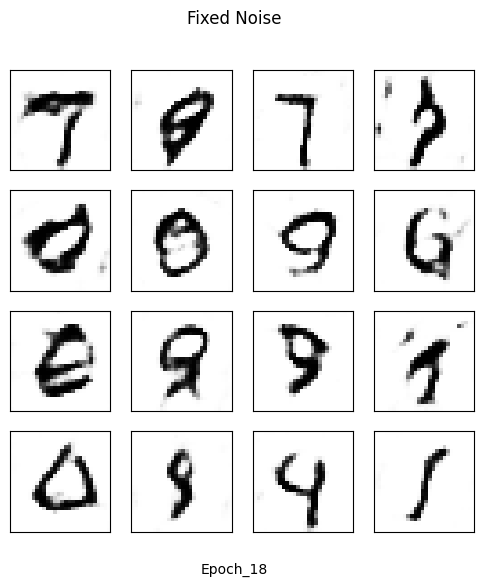

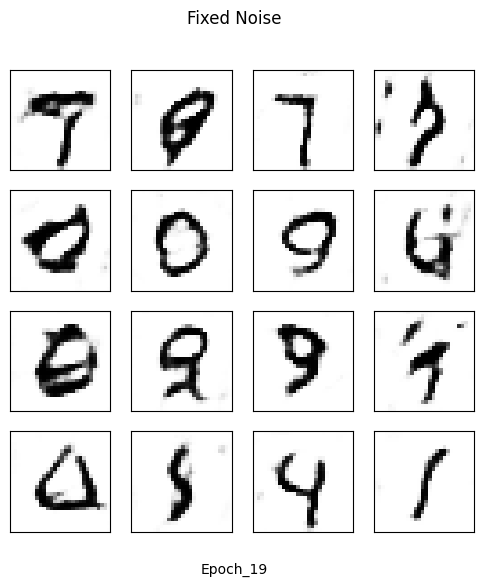

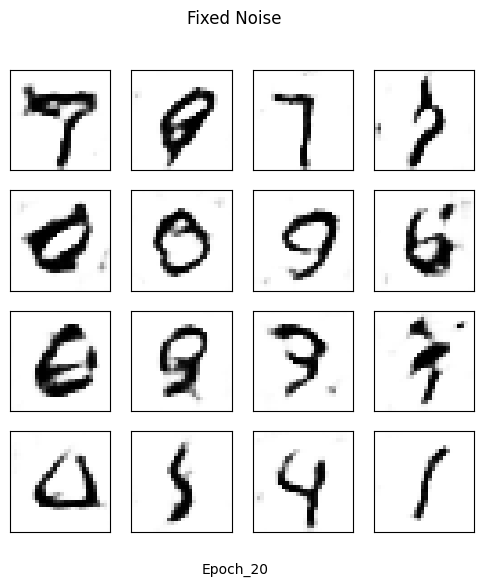

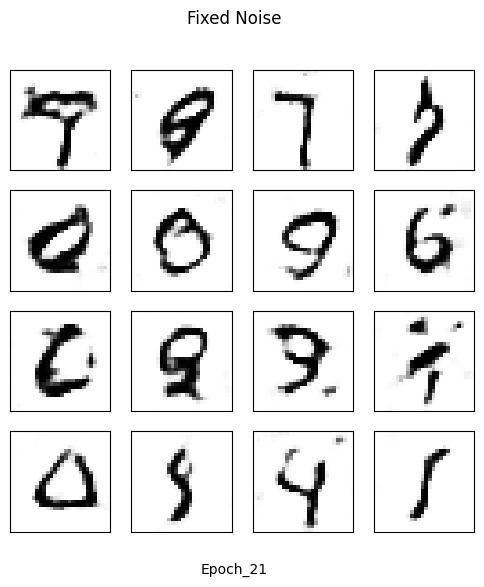

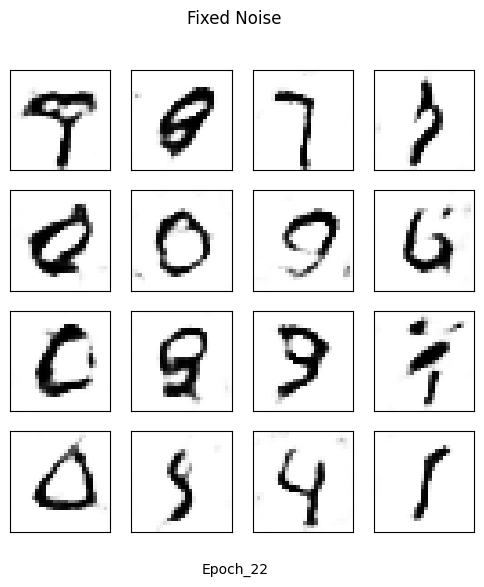

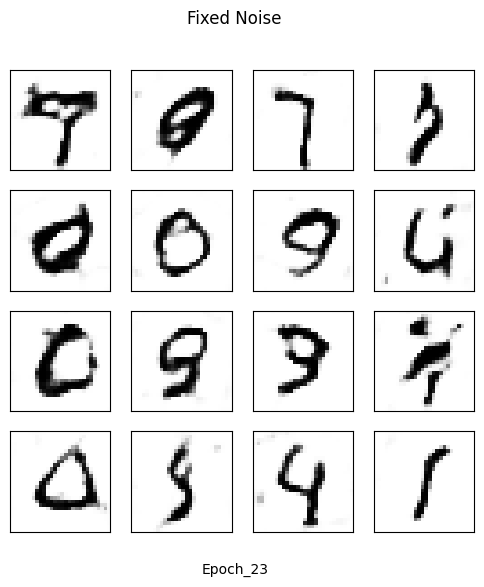

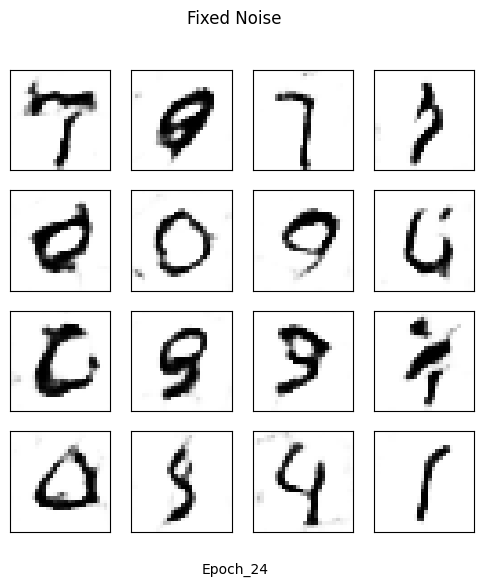

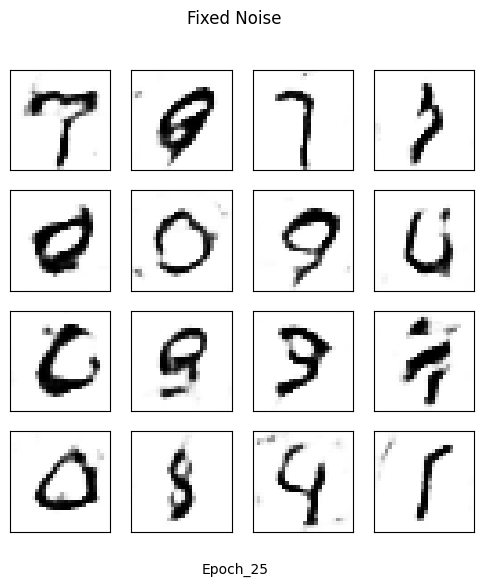

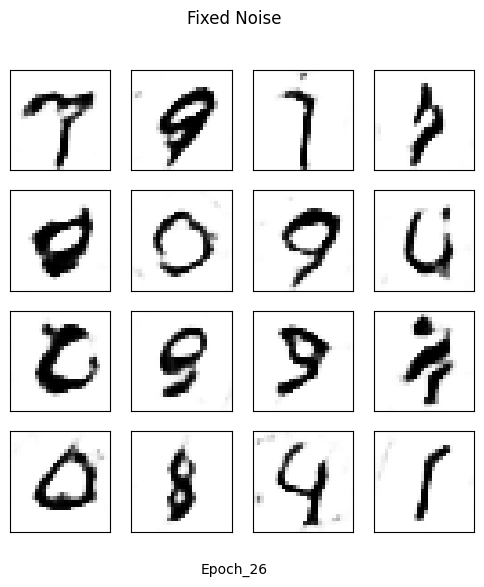

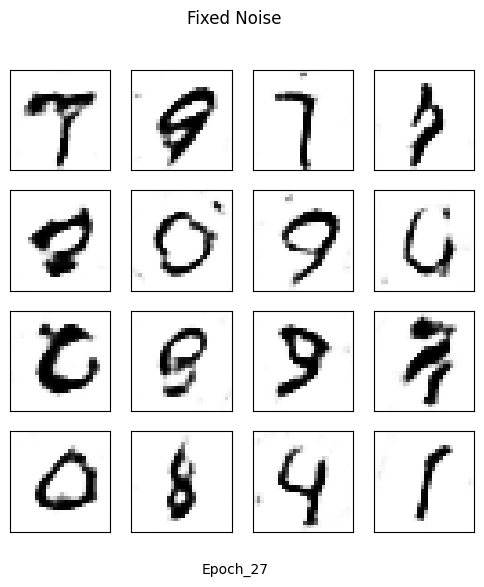

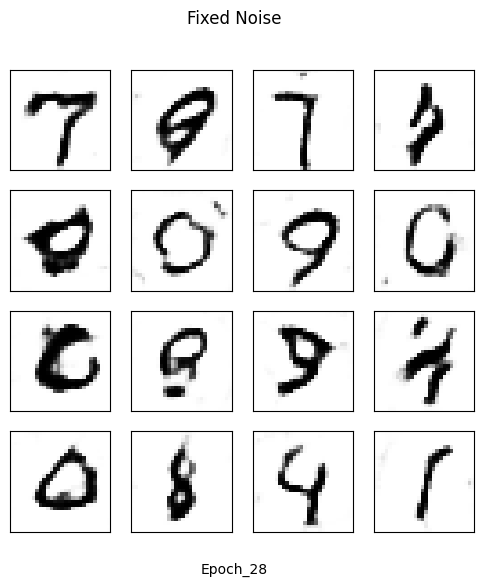

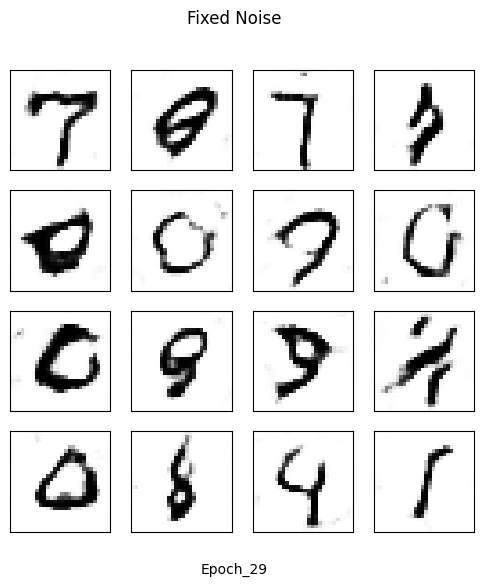

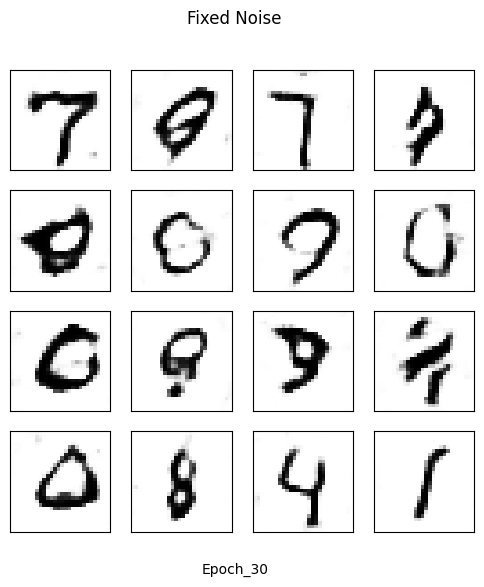

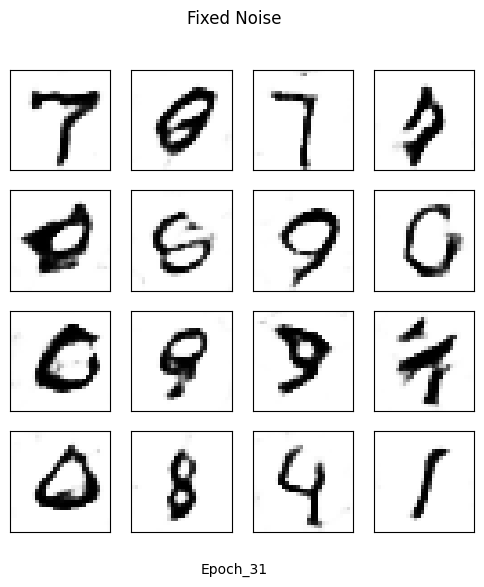

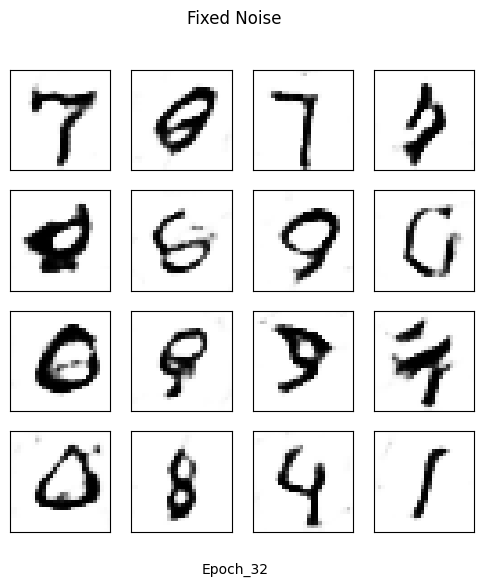

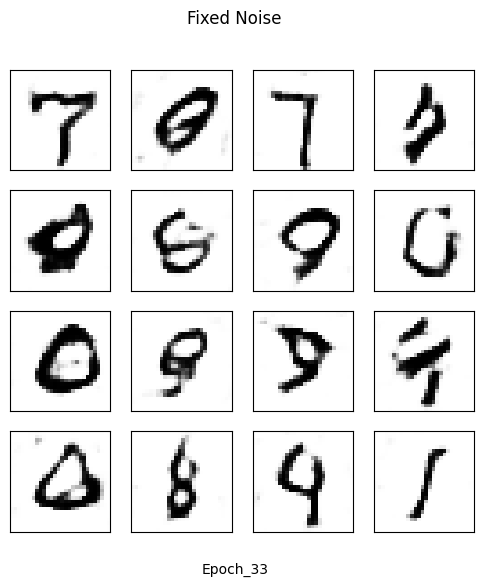

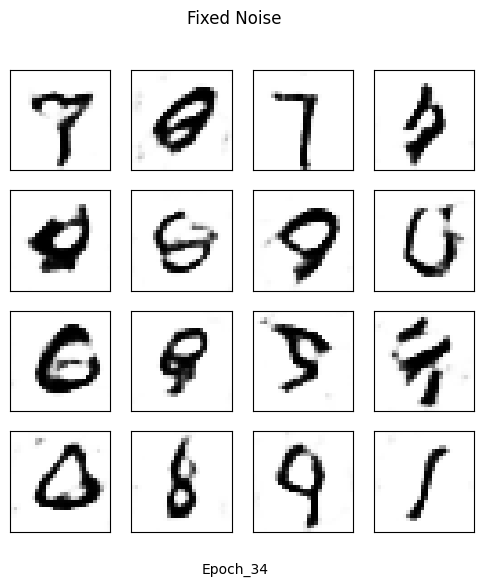

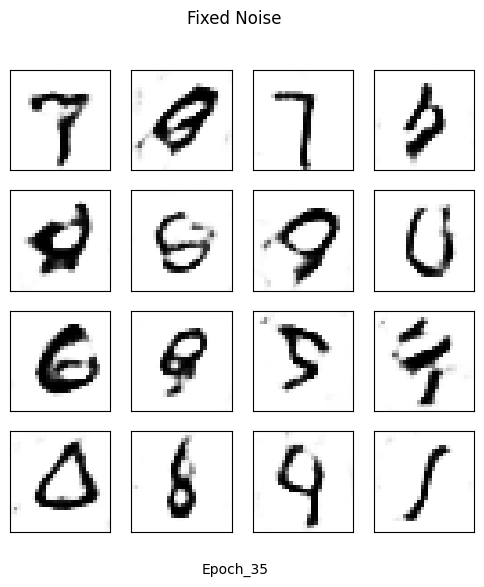

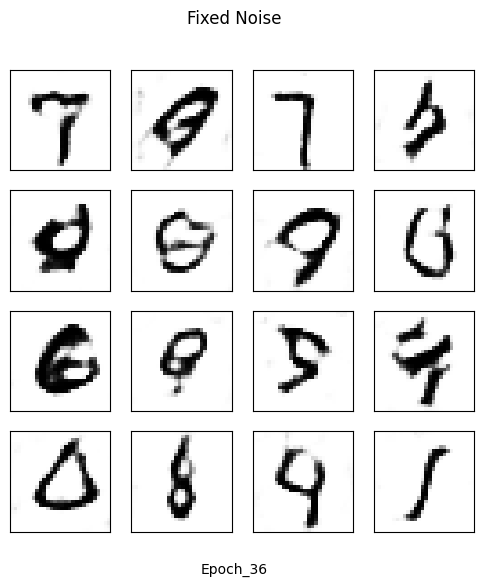

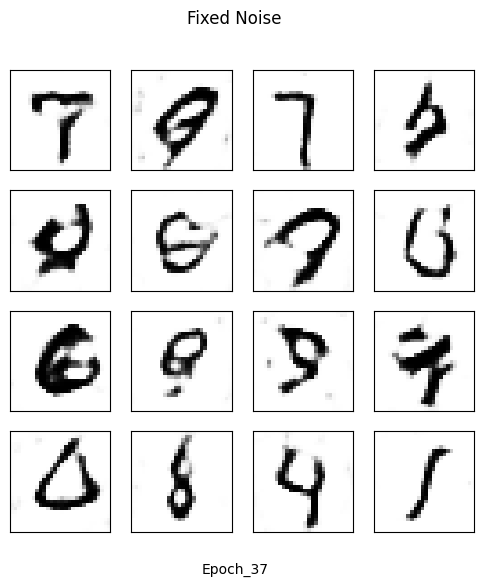

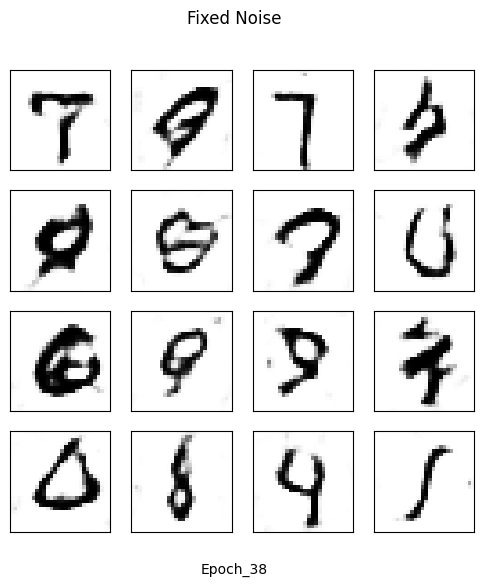

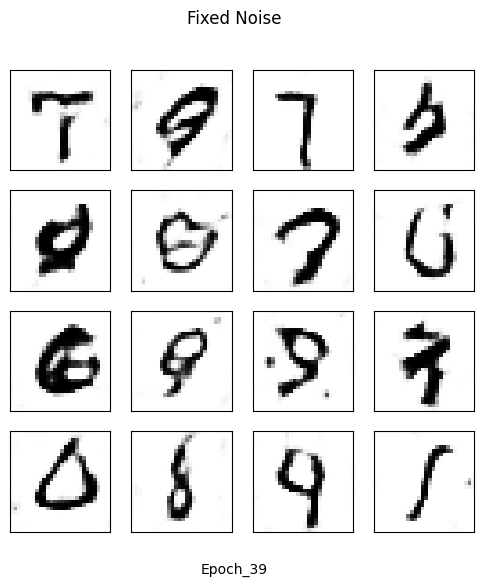

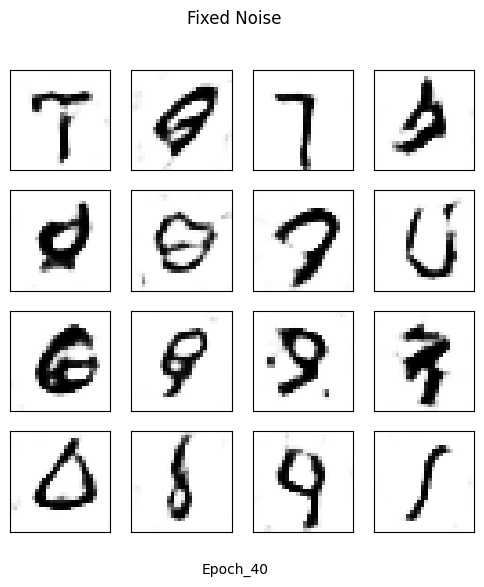

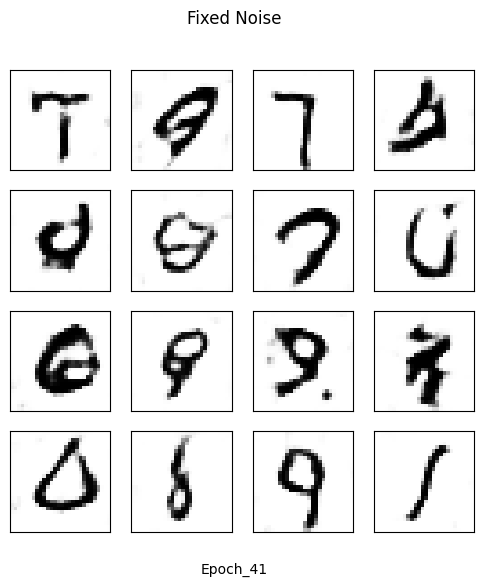

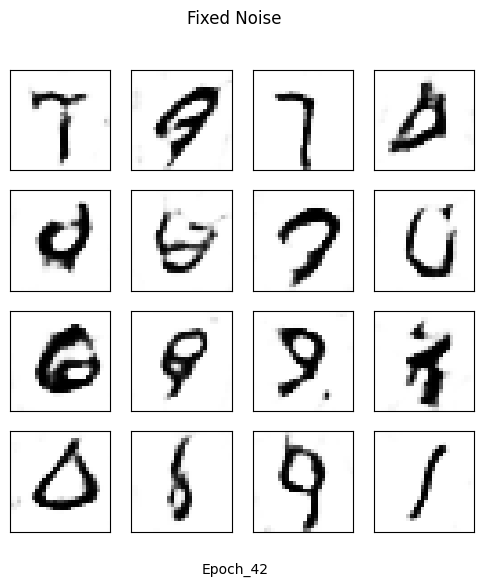

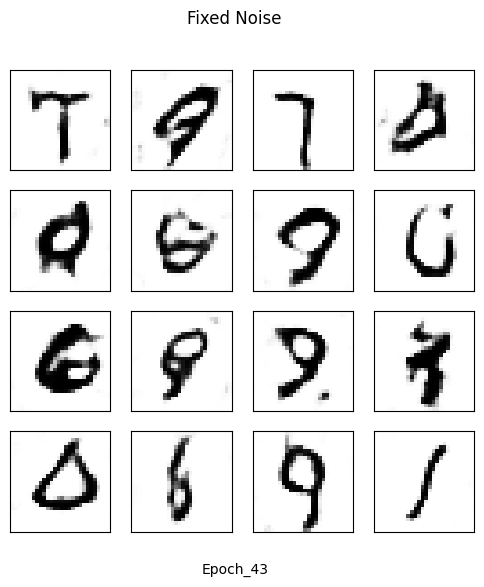

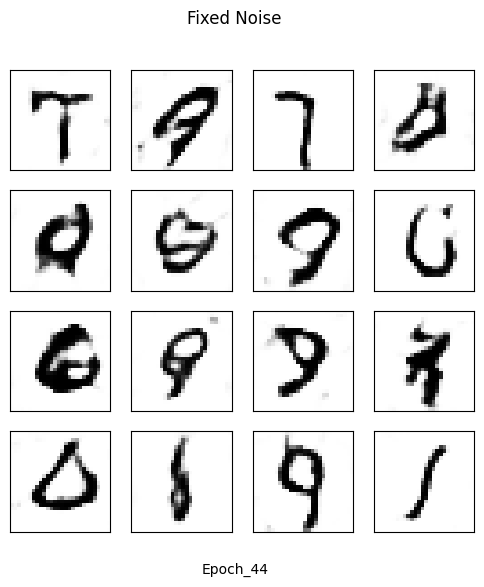

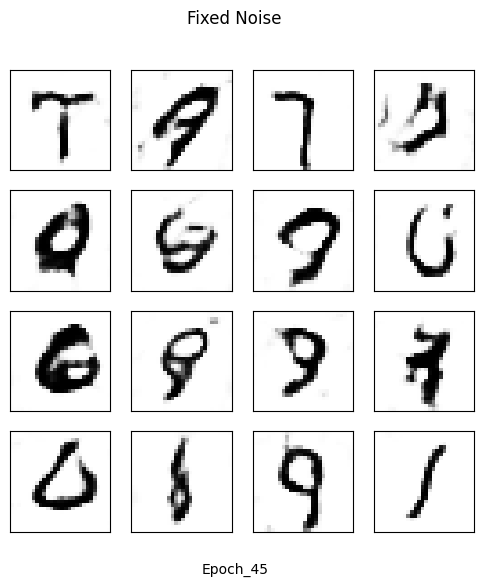

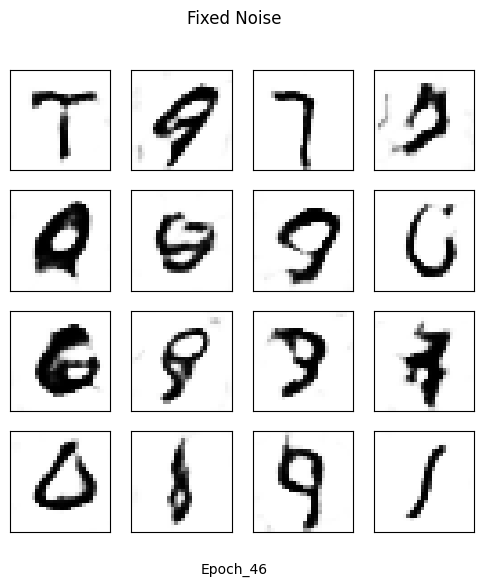

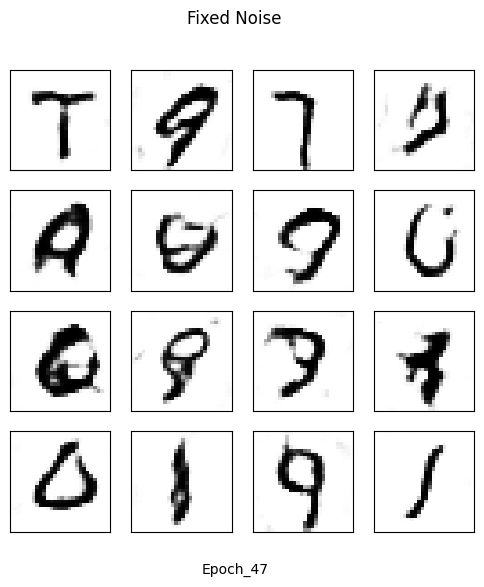

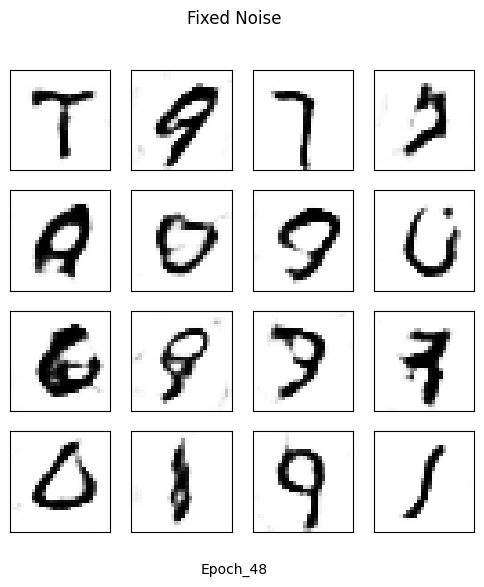

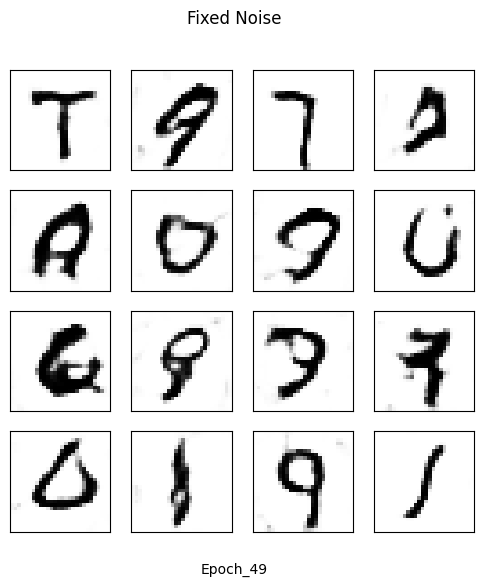

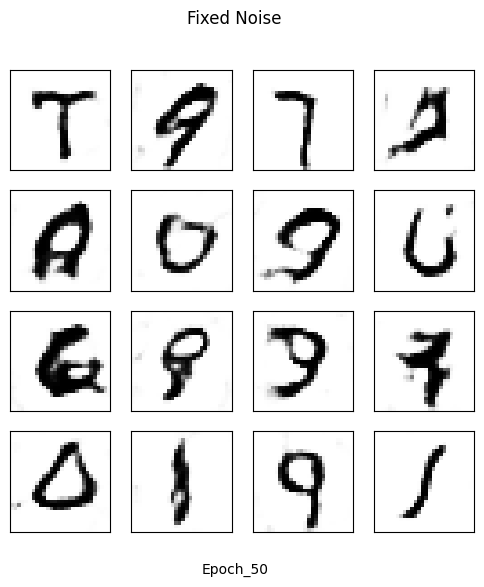

In [34]:
real_label = 1.0
fake_label = 0.0
num_batches = len(dataloader)
fixed_noise = torch.randn(16, 100, 1, 1, device = device)

wd_losses = []
wg_losses = []

num_epochs = 50

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        bs = real_images.shape[0]

        ##############################
        #   Training discriminator   #
        ##############################

        netWGD.zero_grad()
        real_images = real_images.to(device)

        # Реальні зображення
        real_output = netWGD(real_images)
        lossD_real = -torch.mean(real_output)  # Втрата на реальних зображеннях

        # Фейкові зображення
        noise = torch.randn(bs, 100, 1, 1, device=device)
        fake_images = netWGG(noise)
        fake_output = netWGD(fake_images.detach())
        lossD_fake = torch.mean(fake_output)  # Втрата на фейкових зображеннях

        # Загальна втрата дискримінатора
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerWGD.step()

        # Вагове обмеження (weight clipping)
        for p in netWGD.parameters():
            p.data.clamp_(-0.01, 0.01)

        ##########################
        #   Training generator   #
        ##########################

        if i % 5 == 0:  # Оновлюємо генератор раз на 5 кроків
            netWGG.zero_grad()

            fake_output = netWGD(fake_images)
            lossG = -torch.mean(fake_output)  # Втрата генератора

            lossG.backward()
            optimizerWGG.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(
                epoch + 1, num_epochs, i + 1, len(dataloader), lossD.item(), lossG.item()))

    # Логування втрат
    d_epoch_loss = lossD.item()
    g_epoch_loss = lossG.item()
    wd_losses.append(d_epoch_loss)
    wg_losses.append(g_epoch_loss)

    # Генерація зображень після кожної епохи
    netWGG.eval()
    generate_images(epoch, './results/WGAN/', fixed_noise, 16, netWGG, device, use_fixed='store_true')
    netWGG.train()

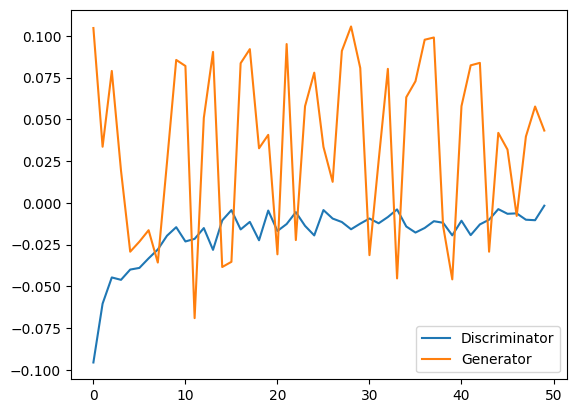

In [37]:
plt.plot(wd_losses, label='Discriminator')
plt.plot(wg_losses, label='Generator')
plt.legend()
plt.show()